This notebook is a backtest of the strategy outlined in the paper.

In [24]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import yaml
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
import seaborn as sns

### Development

Do a per-stock fitting and signal generation, such that data pulling doesn't take too much time. If the fitted beta (market component) does not have data for the entire period of the given stock, then the fallback will be utilised.

In [2]:
load_dotenv()

# .env variables
db_url = os.getenv('DB_URL')
constituents_table = os.getenv('CONSTITUENTS_TABLE')
prices_table = os.getenv('PRICES_TABLE')

# connection to sql database
db_conn = create_engine(db_url)

# config yaml
with open('backtest_config.yaml') as f:
    backtest_cfg = yaml.load(f, Loader=yaml.FullLoader)

sector_betas = backtest_cfg['sector_betas']
backtest_settings = backtest_cfg['backtest']

Remove any duplicate constituents besides the most recent ones (since `yfinance` will only keep the most recent ones).

In [3]:
def fetch_patched_constituents():
    constituents = pd.read_sql(
        f"""
        SELECT * FROM {constituents_table}
        WHERE sector IS NOT NULL
        """,
        db_conn
    )

    available_constituents = pd.read_sql(
        f"""
        SELECT DISTINCT ticker FROM {prices_table}
        """,
        db_conn
    )["ticker"].to_list()

    constituents['end_date'] = pd.to_datetime(constituents['end_date'])
    constituents['end_date_filled'] = constituents['end_date'].fillna(pd.Timestamp.max)

    constituents = (
        constituents.sort_values(['ticker', 'end_date_filled'], ascending=[True, False])
        .drop_duplicates(subset='ticker', keep='first')
        .drop(columns='end_date_filled')
    )

    constituents = constituents[constituents['ticker'].isin(available_constituents)]

    return constituents.set_index('ticker').to_dict(orient='index')

constituents = fetch_patched_constituents()

In [4]:
available_constituents = pd.read_sql(
    f"""
    SELECT DISTINCT ticker FROM {prices_table}
    """,
    db_conn
)["ticker"].to_list()

Now consider the generation of signals.

In [6]:
def generate_edge_leg_df(edge_leg: str) -> pd.DataFrame:
    """
    Generate signals for a given stock ticker (edge_leg).

    Args:
        edge_leg (str): The stock ticker for which signals are generated.

    Returns:
        pd.DataFrame: DataFrame containing sector ETF data for the given stock.
    """
    try:
        # Extract relevant config information for the given edge leg.
        edge_leg_start = constituents[edge_leg]['start_date']
        edge_leg_end = constituents[edge_leg]['end_date'] if constituents[edge_leg]['end_date'] is not pd.NaT else date.today()
        sector = constituents[edge_leg]['sector']
        sector_beta = sector_betas[sector]['beta']

        edge_data_query = f"""
            SELECT date, ticker, adj_close FROM adjusted_historical
            WHERE ticker = '{edge_leg}'
        """
        edge_data = pd.read_sql(edge_data_query, db_conn)

        sector_etf_query = f"""
            SELECT date, ticker, adj_close FROM adjusted_historical
            WHERE ticker = '{sector_beta}'
            AND date >= '{edge_leg_start}'
            AND date <= '{edge_leg_end}'
        """
        sector_etf_data = pd.read_sql(sector_etf_query, db_conn)

        # Ensure date column is in datetime format
        edge_data['date'] = pd.to_datetime(edge_data['date'])
        sector_etf_data['date'] = pd.to_datetime(sector_etf_data['date'])

        # We only want to test for days where the etf was also trading.
        edge_data = edge_data[edge_data['date'].isin(sector_etf_data['date'])]

        # Get (log) returns column for both edge and sector data
        edge_data['log_returns'] = np.log(edge_data['adj_close'] / edge_data['adj_close'].shift())
        sector_etf_data['log_returns'] = np.log(sector_etf_data['adj_close'] / sector_etf_data['adj_close'].shift())

        backtest_data = pd.concat([edge_data, sector_etf_data]).sort_values('date').dropna().reset_index(drop=True)

        return backtest_data
        

    except KeyError as e:
        print(f"KeyError: {e}. Check if edge_leg exists in constituents.")
        raise
    except Exception as e:
        print(f"An error occurred while generating signals: {e}")
        raise

def generate_signals(edge_leg_df: pd.DataFrame, edge_leg: str, hedge_leg: str) -> pd.DataFrame:
    """
    Returns the trading signals (as entry as well as s-score) for the edge leg.
    """
    def s_score(window_data: np.array) -> float:
        """
        Calculate s-score following Avellaneda-Lee methodology with proper exclusion criteria.
        
        The paper specifies that we should exclude stocks where:
        1. kappa = -log(b) * 252 is too small (indicating slow mean reversion)
        2. b parameter is outside acceptable bounds
        3. The half-life of mean reversion is too long
        """
        try:
            if len(window_data) < 10:  # Minimum data requirement
                return np.nan
                
            X_k = np.cumsum(window_data)                             
            X_n_plus_one = X_k[1:]                                     
            X_n = X_k[:-1]                                              

            ou_model = LinearRegression().fit(X_n.reshape(-1, 1), X_n_plus_one)

            # OU process parameters as defined in the paper
            a = ou_model.intercept_
            b = ou_model.coef_[0]  # Extract scalar value
            zeta = X_n_plus_one - ou_model.predict(X_n.reshape(-1, 1))

            # Avellaneda-Lee exclusion criteria
            if b <= 0 or b >= 0.9672:
                return np.nan
                
            kappa = -np.log(b) * 252
            
            if kappa <= 252 / 30:
                return np.nan

            
            m = a / (1 - b)  
            sigma_eq = np.sqrt(np.var(zeta) / (1 - b ** 2)) 

            s_score_value = -m / sigma_eq
            
            return s_score_value
            
        except (np.linalg.LinAlgError, ValueError, ZeroDivisionError) as e:
            # Handle numerical issues gracefully
            return np.nan
        except Exception as e:
            return np.nan
    
    def rolling_apply(series: pd.Series, window: int, func) -> pd.Series:
        result = np.full(len(series), np.nan)
        arr = series.to_numpy()
        for i in range(window, len(arr)):
            result[i] = func(arr[i - window:i])
        return pd.Series(result, index=series.index)

    def fill_positions_from_s_score(s_score_series: pd.Series) -> pd.Series:
        """
        Implements Avellaneda & Lee threshold logic:
        - Entry short at >= +1.25, exit short at < +0.75
        - Entry long at <= -1.25, exit long at > -0.5
        """
        position = 0
        positions = []

        for score in s_score_series:
            if pd.isna(score):  # Skip NaN values
                positions.append(0)
                continue
                
            if position == 0:
                if score >= 1.25:
                    position = -1  # Enter short
                elif score <= -1.25:
                    position = 1   # Enter long
            elif position == -1:
                if score < 0.75:
                    position = 0  # Exit short
            elif position == 1:
                if score > -0.5:
                    position = 0  # Exit long

            positions.append(position)

        return pd.Series(positions, index=s_score_series.index, name='position')

    W = backtest_settings['lookback']

    wide = (edge_leg_df
            .pivot(index='date', columns='ticker', values='log_returns')
            [[edge_leg, hedge_leg]]
            .sort_index()
            .dropna())
    y = wide[edge_leg]
    x = wide[hedge_leg]

    """
    Below is an efficient implementation for finding OLS residuals.
    It finds the rolling means, the rolling residual from the mean, and from this calculates
    the variance and covariance. This then allows us to find the beta and alpha.
    """
    mx = x.rolling(W, min_periods=W).mean()
    my = y.rolling(W, min_periods=W).mean()

    x_dev = x - mx
    y_dev = y - my

    var_x = (x_dev.pow(2)).rolling(W, min_periods=W).sum()
    cov_xy = (x_dev * y_dev).rolling(W, min_periods=W).sum()

    beta = (cov_xy / var_x).shift(1)
    alpha = (my - beta * mx).shift(1)

    fitted = alpha + beta * x
    residual = (y - fitted).dropna()

    """
    We then calculate the s-score. This is an estimation of the residual process and can be 
    found in the appendix of the paper.
    """

    s_score_results = rolling_apply(residual, W, s_score)
    s_score_results.name = 's_score'
    s_score_df = s_score_results.dropna().reset_index()

    s_score_df['edge_leg'] = edge_leg
    s_score_df['hedge_leg'] = hedge_leg
    s_score_df['signal'] = fill_positions_from_s_score(s_score_df['s_score'])

    # merge in log returns
    wide = wide.rename(columns={
        edge_leg: 'log_return_edge',
        hedge_leg: 'log_return_hedge'
    })

    return pd.merge(s_score_df, wide, on='date', how='left')

In [7]:
msft = generate_edge_leg_df('MSFT')
msft_pos = generate_signals(msft, 'MSFT', 'XLK')

In [8]:
msft_pos

,date,s_score,edge_leg,hedge_leg,signal,log_return_edge,log_return_hedge
0,1999-09-13,-3.115604,MSFT,XLK,1,-0.011916,-0.013723
1,1999-09-14,-2.376735,MSFT,XLK,1,0.012571,0.010849
2,1999-09-15,-1.409619,MSFT,XLK,1,-0.025975,-0.021084
3,1999-09-16,-0.475027,MSFT,XLK,0,0.014738,-0.004419
4,1999-09-17,-0.764158,MSFT,XLK,0,0.025600,0.019731
...,...,...,...,...,...,...,...
5497,2025-07-11,-0.542565,MSFT,XLK,1,0.003662,-0.004407
5498,2025-07-14,-0.994224,MSFT,XLK,1,-0.000596,-0.000821
5499,2025-07-15,-1.525619,MSFT,XLK,1,0.005551,0.008840
5500,2025-07-16,-2.325387,MSFT,XLK,1,-0.000395,0.003097


### Filling in all constituents

We now consider the performance of the strategy across ~25 years, across the entire universe available to us.

In [9]:
positions = []

for ticker in available_constituents:
    print(ticker)
    try:
        edge_leg = ticker
        sector = constituents[ticker]['sector']
        hedge_leg = sector_betas[sector]['beta']

        edge_leg_df = generate_edge_leg_df(edge_leg)
        position_df = generate_signals(edge_leg_df, edge_leg, hedge_leg)
        positions.append(position_df)
    except Exception as e:
        print(e)

CLF
VFC
BDK
'BDK'
RSG
TKO
BBWI
EXPD
INVH
DDR
'DDR'
GWW
COV
'COV'
ANSS
O
IFF
BR
V
SOLV
NWL
CCI
HPE
TRV
HP
AVGO
PFE
EFX
BRO
ROP
VRTX
AMP
TER
LUMN
AMZN
VRSN
JEF
SGP
'SGP'
HES
AAP
BAC
MTCH
DTE
HET
'HET'
LEG
NUE
CE
EA
MSI
URBN
JWN
HRB
FI
BBY
PCAR
MHK
AET
'AET'
GLK
'GLK'
SHW
SNPS
ENPH
AON
TXN
DXC
ZION
KSS
ES
STE
BA
PSX
ASN
'ASN'
TWX
'TWX'
TDC
HAL
FTI
SCG
'SCG'
ON
BOL
'BOL'
PHM
AN
HOT
'HOT'
MPC
L
PRU
FOXA
MMM
UNH
NOW
DD
AYE
'AYE'
AKAM
TRB
'TRB'
DG
TFX
NVR
CRM
MTW
PKG
HOLX
DDS
CVS
SNT
CPRI
MAC
PRGO
TLAB
'TLAB'
NYT
"None of [Index(['NYT', 'XLC'], dtype='object', name='ticker')] are in the [columns]"
AES
ELV
ALGN
M
PNR
PLD
MCIC
"None of [Index(['MCIC', 'XLV'], dtype='object', name='ticker')] are in the [columns]"
GRMN
DUK
CTSH
UPS
CZR
PAYC
MMC
SWKS
D
PENN
IDXX
CCU
TRMB
RMD
CVG
'CVG'
FTV
BRL
'BRL'
WDAY
TECH
JNY
'JNY'
CMVT
'CMVT'
ZTS
ARE
BMY
HUM
LDOS
AMAT
TROW
EMN
HON
RX
'RX'
NEE
HIG
ABT
EVHC
'EVHC'
PG
XLC
'XLC'
ALL
EXE
COR
DHI
KRB
'KRB'
SPG
SLG
BWA
QRVO
AMGN
USB
BIO
LKQ
STT
MLM
GEN
SBAC
ESRX
'ESR

In [10]:
strategy_history = pd.concat(positions).sort_values('date').reset_index(drop=True)

First, let us complete a strategy-wide analysis of returns, dividing by total, long and short returns.

In [11]:
strategy_longs = strategy_history[strategy_history['signal'] == 1].copy()
strategy_shorts = strategy_history[strategy_history['signal'] == -1].copy()

In [12]:
strategy_longs['return'] = (strategy_longs['log_return_edge'] - strategy_longs['log_return_hedge'])
strategy_shorts['return'] = -(strategy_shorts['log_return_edge'] - strategy_shorts['log_return_hedge'])

strategy_total = pd.concat([strategy_longs, strategy_shorts]).sort_values('date')
strategy_total['cum_return'] = strategy_total['return'].cumsum()

In [13]:
strategy_total_returns = strategy_total['return'].cumsum()

Text(0.5, 1.0, 'Adverse selection in the dot-com crash and GC greatly affect performance')

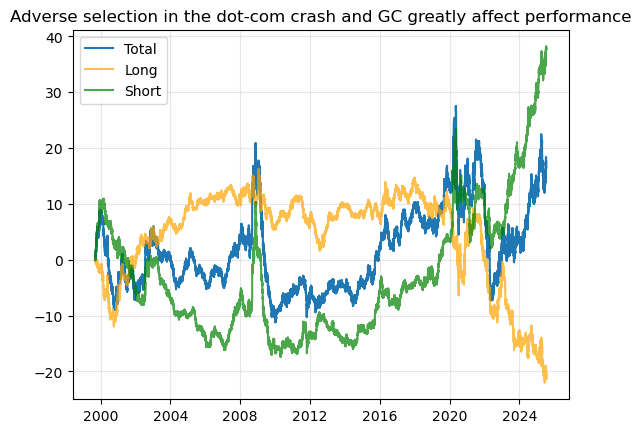

In [32]:
plt.plot(strategy_total['date'], strategy_total['cum_return'], label='Total')
plt.plot(strategy_longs['date'], strategy_longs['return'].cumsum(), color='orange', label='Long', alpha=0.7)
plt.plot(strategy_shorts['date'], strategy_shorts['return'].cumsum(), color='green', label='Short', alpha=0.7)
plt.grid(alpha=0.3)
plt.legend()
plt.title('Adverse selection in the dot-com crash and GC greatly affect performance')

Certaily some strong adverse selection going on during the `.com` crash, `GFC` and `COVID`. What happens if we remove these periods?

In [ ]:
adverse_periods = [
    ('2000-03-01', '2004-10-01'),  # Dot-com bust
    ('2008-09-01', '2009-04-01'),  # GFC
    ('2020-02-15', '2020-04-01'),  # COVID crash
    ('2025-04-01', '2025-05-01'),  # Tariff/vol spike
]

mask = pd.Series(True, index=strategy_total.index)

for start, end in adverse_periods:
    mask &= ~strategy_total['date'].between(start, end)

no_adverse = strategy_total[mask].copy()

In [37]:
no_adverse['cum_return'] = no_adverse['return'].cumsum()

In [40]:
no_adverse_long = no_adverse[no_adverse['signal'] == 1].copy()
no_adverse_short = no_adverse[no_adverse['signal'] == -1].copy()

no_adverse_long['return'] = no_adverse_long['log_return_edge'] - no_adverse_long['log_return_hedge']
no_adverse_long['return'] = no_adverse_long['log_return_hedge'] - no_adverse_long['log_return_edge']

no_adverse_total = pd.concat([no_adverse_long, no_adverse_short]).sort_values('date')
no_adverse_total['cum_return'] = no_adverse_total['return'].cumsum()

Text(0.5, 1.0, 'Adverse selection in the dot-com crash and GC greatly affect performance')

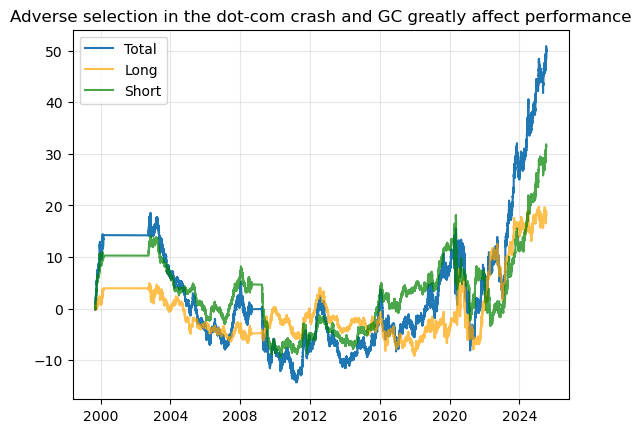

In [42]:
plt.plot(no_adverse_total['date'], no_adverse_total['cum_return'], label='Total')
plt.plot(no_adverse_long['date'], no_adverse_long['return'].cumsum(), color='orange', label='Long', alpha=0.7)
plt.plot(no_adverse_short['date'], no_adverse_short['return'].cumsum(), color='green', label='Short', alpha=0.7)
plt.grid(alpha=0.3)
plt.legend()
plt.title('Adverse selection in the dot-com crash and GC greatly affect performance')